# Predicting Customer Defaults on their Loan
#### Please see the explanations and results at the end of this page.

In [1]:
#Begin by importing the main libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Classification algorithms used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#Optimization, scaling, splitting data, stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize

#Evaluating models, preprocessing
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.special import boxcox

# Over and Under Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Measuring processing time each algorithms takes
import time

#Filtering warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Begin by loading the "UCI Credit Card" data.
data=pd.read_csv("UCI_Credit_Card.csv")

### Phase 1: Data Cleaning

In [3]:
#Getting information about the data
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Every variable is numeric.

In [4]:
#Get shape of the data
data.shape

(30000, 25)

In [5]:
#Rename the default column for simplicity and drop ID column(unnececary)
data.rename(columns={'default.payment.next.month':'default','PAY_0':'PAY_1'}, inplace=True)
data.drop("ID", axis=1, inplace=True)

In [6]:
#By inspecting the output above, I can see that there are no missing values. I will confirm this below as well. 
data.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [7]:
#Checking number of unique values in each category
data.nunique()

LIMIT_BAL       81
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             56
PAY_1           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    22723
BILL_AMT2    22346
BILL_AMT3    22026
BILL_AMT4    21548
BILL_AMT5    21010
BILL_AMT6    20604
PAY_AMT1      7943
PAY_AMT2      7899
PAY_AMT3      7518
PAY_AMT4      6937
PAY_AMT5      6897
PAY_AMT6      6939
default          2
dtype: int64

In [8]:
#Checking unique values for marriage, education, sex
print("Unique marriage values: ", data.MARRIAGE.unique())
print("Unique education values: ",data.EDUCATION.unique())
print("Unique sex values: ",data.SEX.unique())

Unique marriage values:  [1 2 3 0]
Unique education values:  [2 1 3 5 4 6 0]
Unique sex values:  [2 1]


Marriage variable: 3 and 0 are the same. Education variable: 4, 5, and 6 are the same. Combine them into one.

In [9]:
#For personal preference, I will represent values in catogorical variables as string types. This is not necessary. 
data.SEX.replace({1:'Male', 2:'Female'},inplace=True)
data.EDUCATION.replace({0:"Other",1:"Graduate",2:"University",3:"Highschool",4:"Other",5:"Other",6:"Other"},inplace=True)
data.MARRIAGE.replace({1:"Married",2:"Single",3:"Other",0:"Other"},inplace=True)
data.default.replace({1:"Yes",0:"No"}, inplace=True)

In [10]:
#Checking unique values for PAY
data.PAY_1.unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6])

In [11]:
#Combine -2 and -1 and represent them as 0.
data.PAY_1.replace({-2:0,-1:0}, inplace=True)
data.PAY_2.replace({-2:0,-1:0}, inplace=True)
data.PAY_3.replace({-2:0,-1:0}, inplace=True)
data.PAY_4.replace({-2:0,-1:0}, inplace=True)
data.PAY_5.replace({-2:0,-1:0}, inplace=True)
data.PAY_6.replace({-2:0,-1:0}, inplace=True)

In [12]:
#Check outliers for continuous variables
continuous_var=list(data.select_dtypes(include='float64').columns)
len(continuous_var)

13

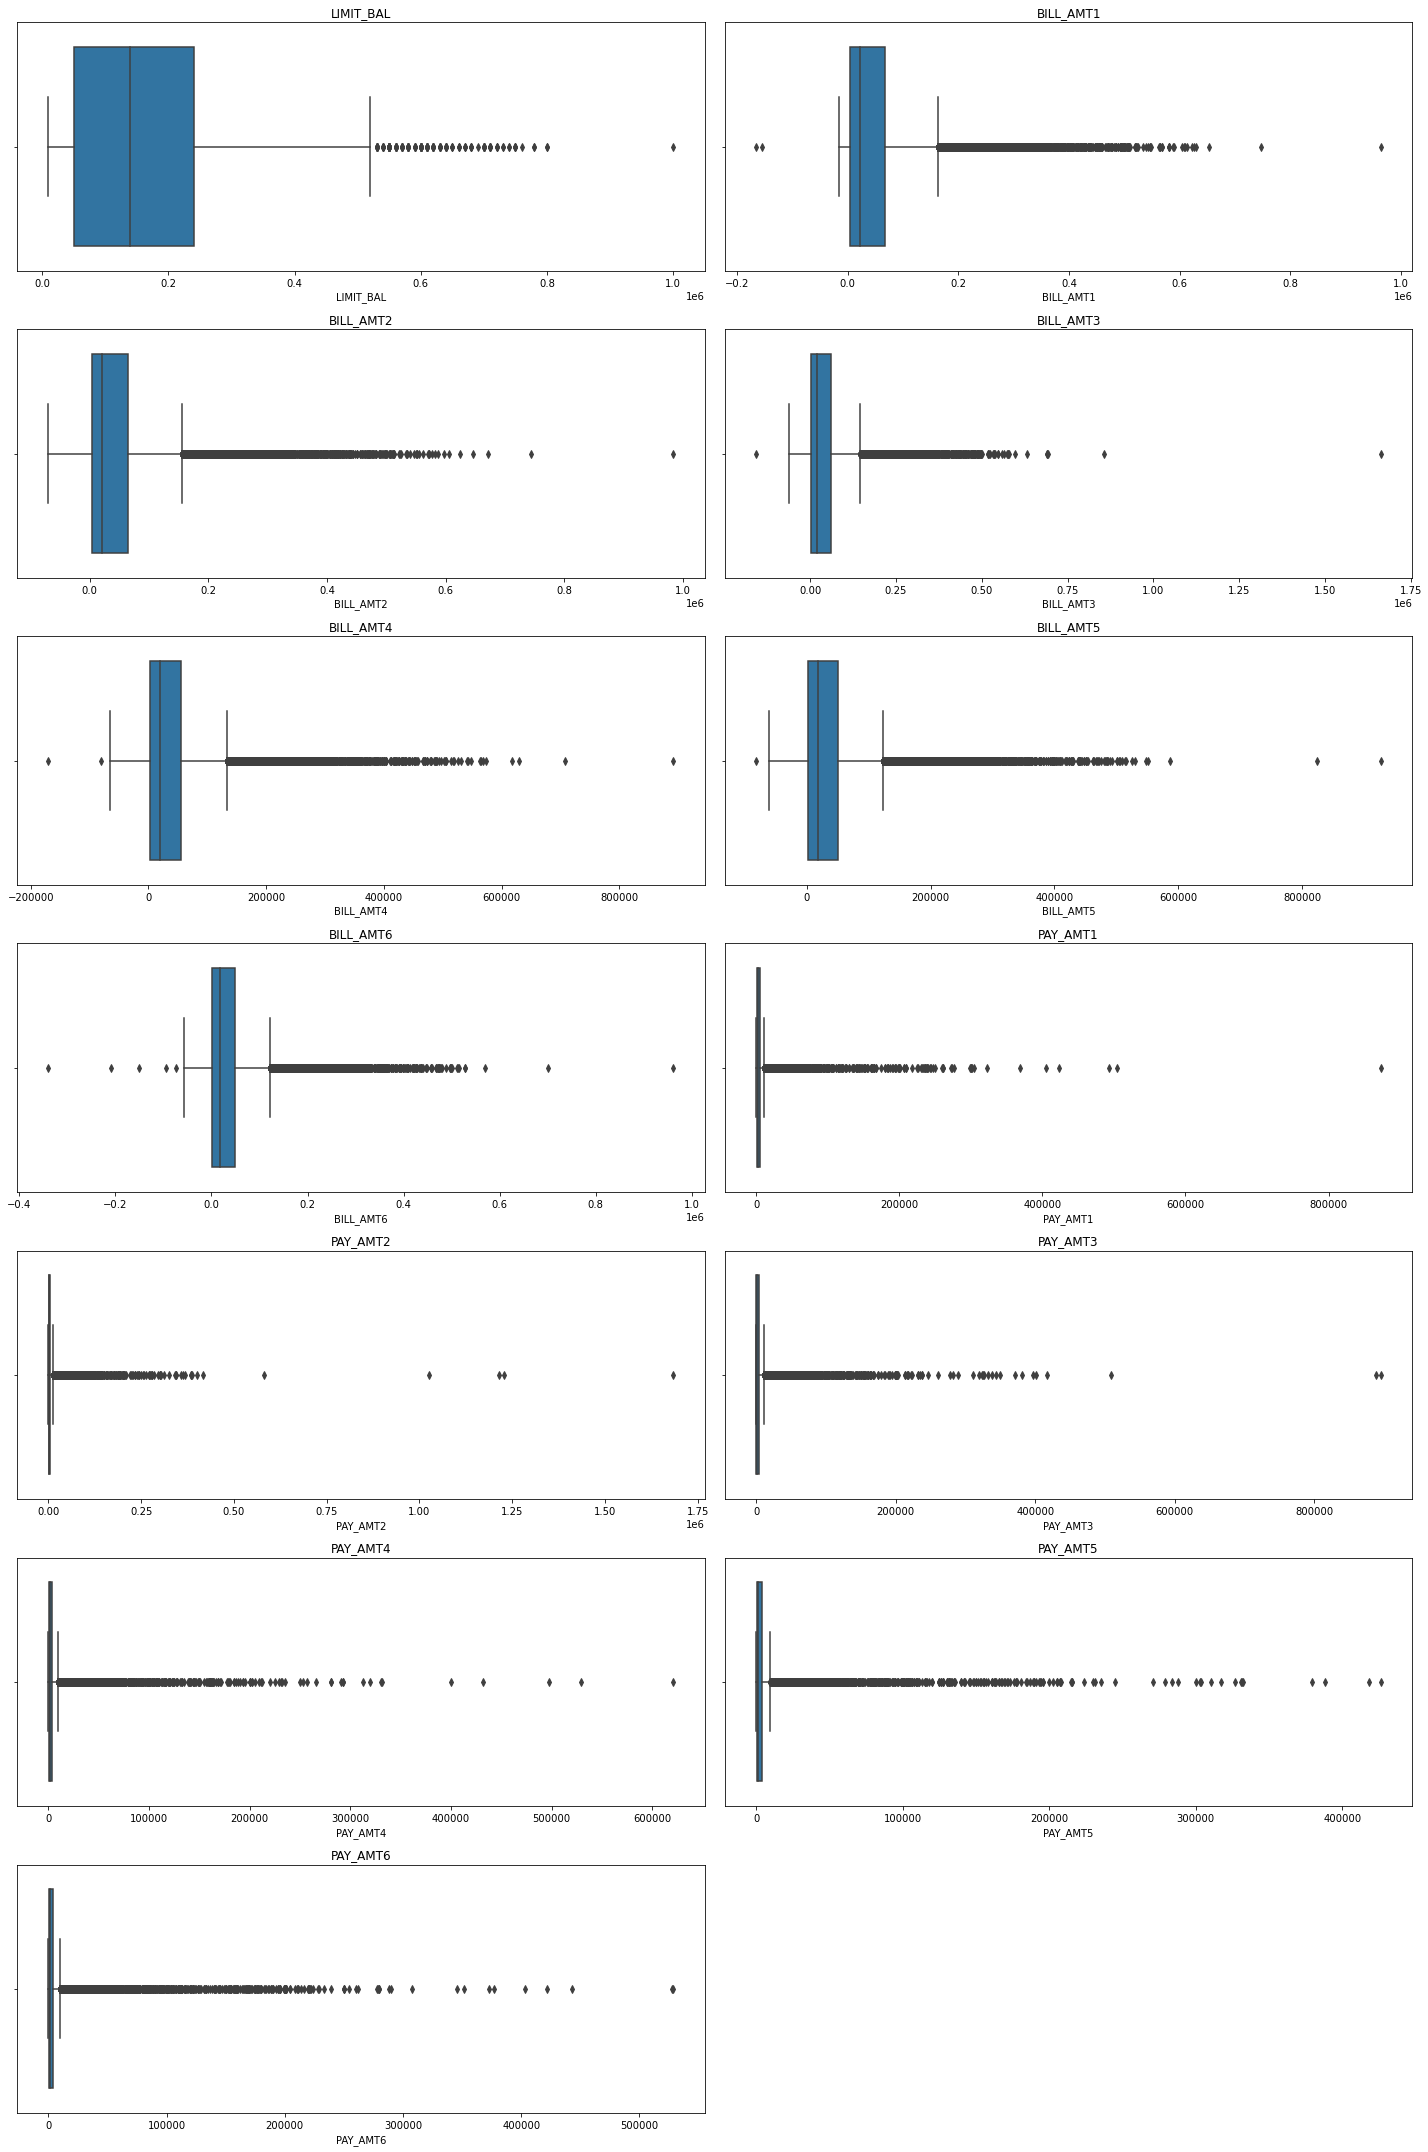

In [13]:
#Checking outliers using boxplot
k=1
plt.figure(figsize=(20,30))
for i in continuous_var:
    plt.subplot(7,2, k)
    k=k+1
    sns.boxplot(x=data[i])  
    plt.title(i)
plt.tight_layout()


In [14]:
#There are outliers in every continuous variable. Using winsorize technique to set limit. Change lowest and highest 0.1%
for i in range(len(continuous_var)):
    data[continuous_var[i]]=winsorize(data[continuous_var[i]], (0.001,.001))

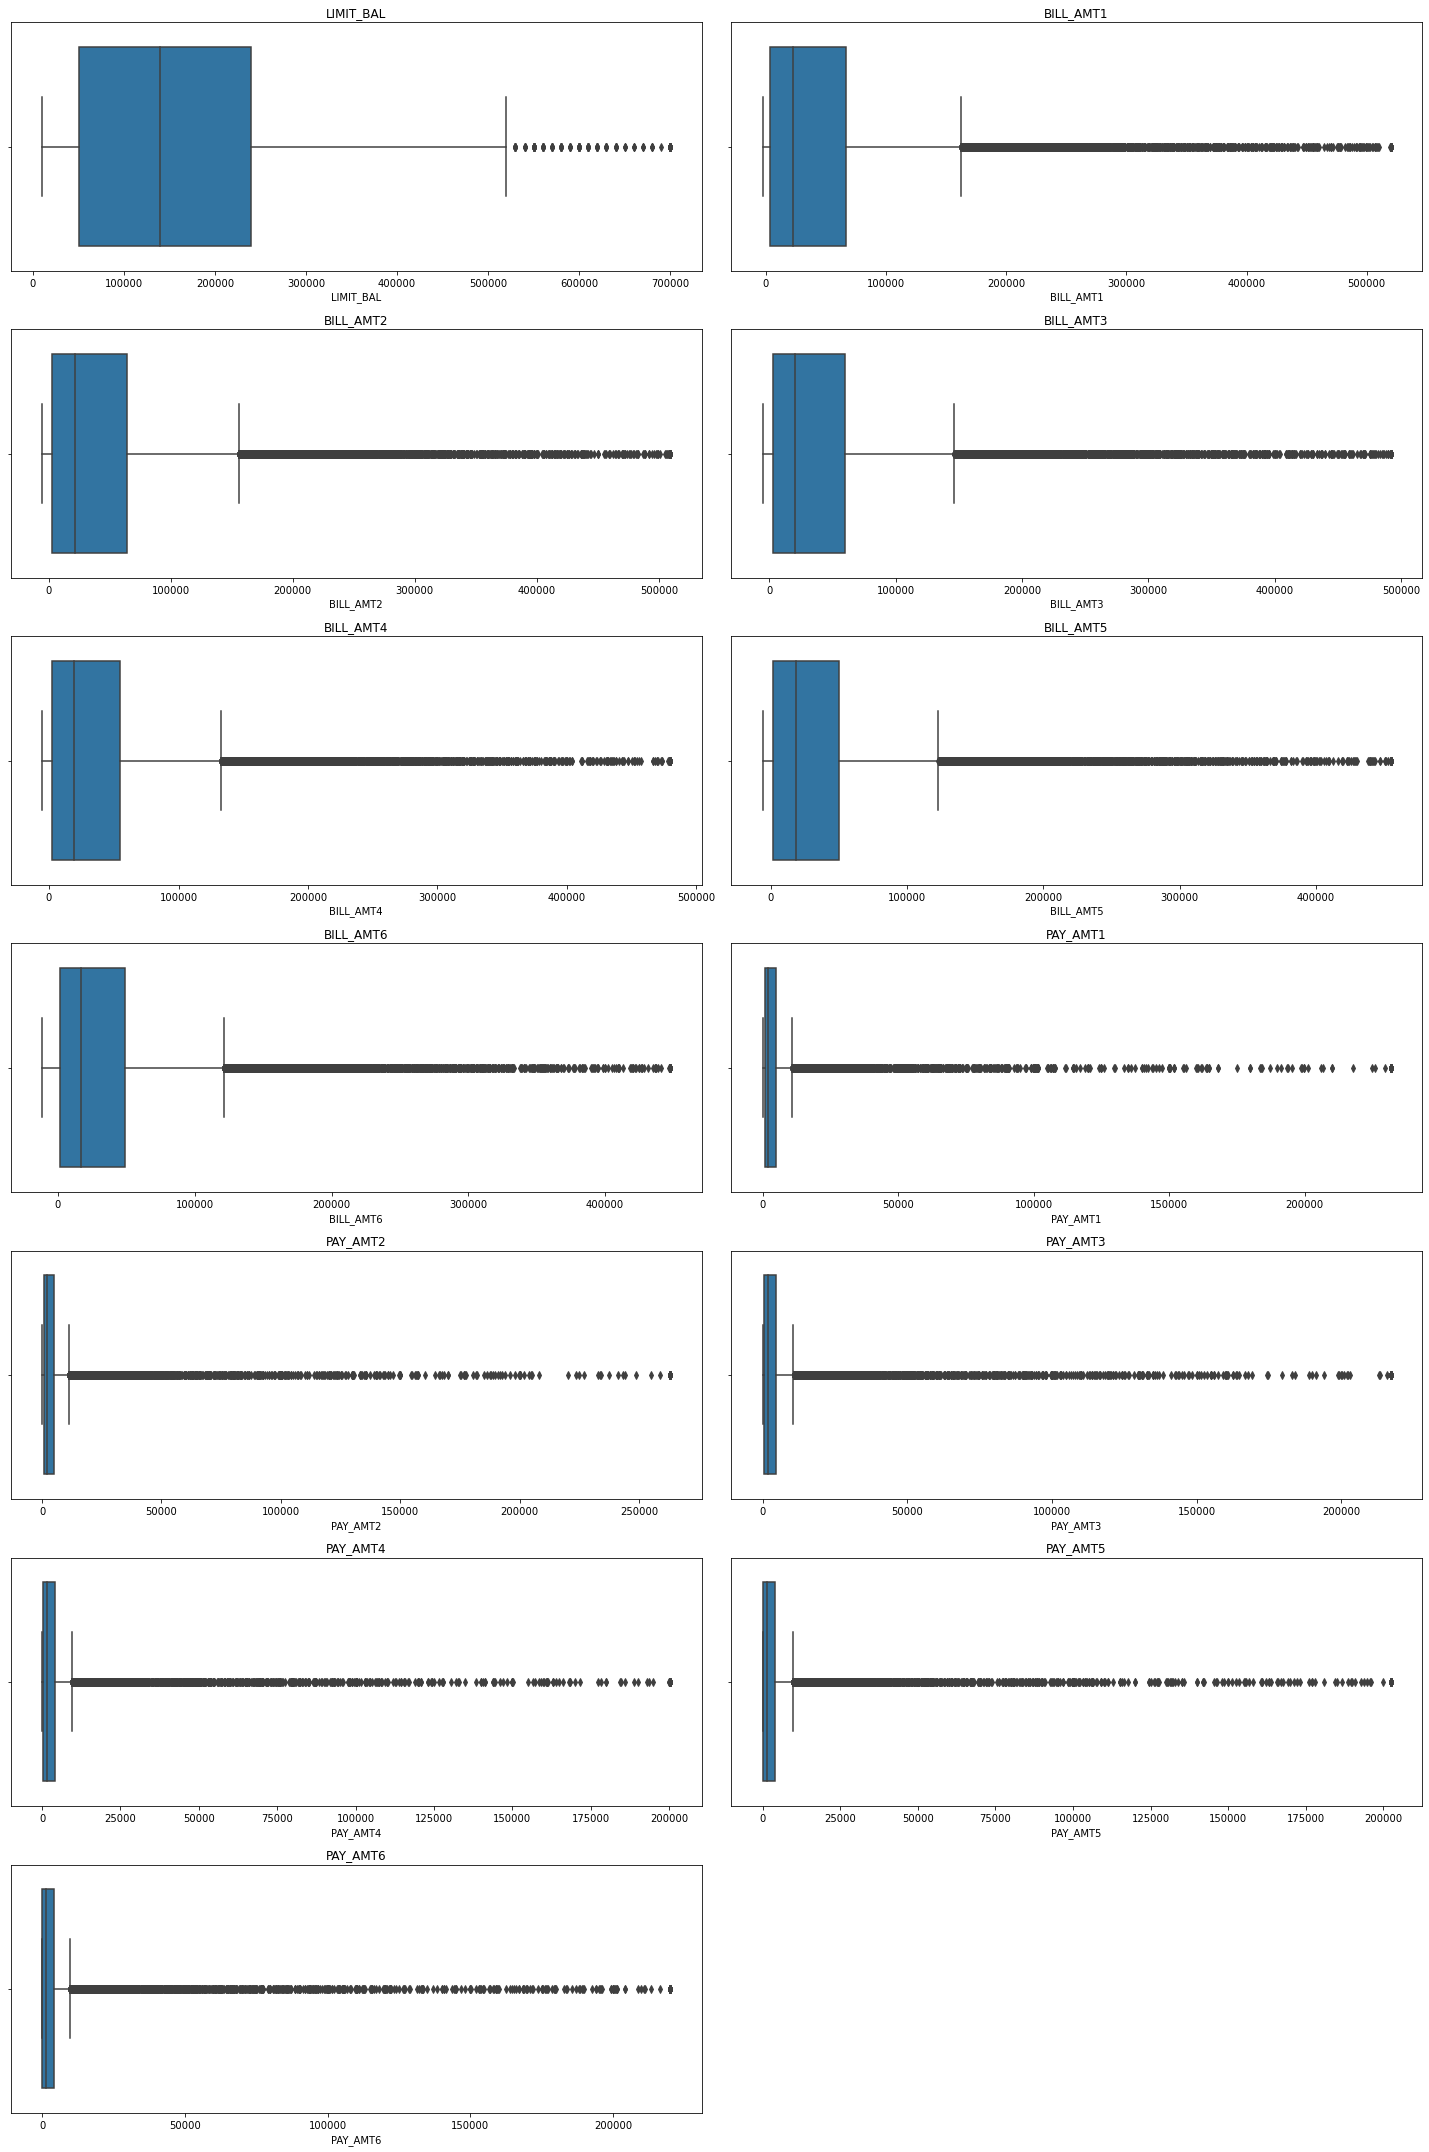

In [15]:
#Checking outliers using boxplot
k=1
plt.figure(figsize=(20,30))
for i in continuous_var:
    plt.subplot(7,2, k)
    k=k+1
    sns.boxplot(x=data[i])  
    plt.title(i)
plt.tight_layout()

Extreme outliers are winsorized. 

In [16]:
#Confirm if data is cleaned
data.head(20)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,Female,University,Married,24,2,2,0,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,Yes
1,120000.0,Female,University,Single,26,0,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,Yes
2,90000.0,Female,University,Single,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,No
3,50000.0,Female,University,Married,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,No
4,50000.0,Male,University,Married,57,0,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,No
5,50000.0,Male,Graduate,Single,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,No
6,500000.0,Male,Graduate,Single,29,0,0,0,0,0,...,479800.0,454845.0,447543.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,No
7,100000.0,Female,University,Single,23,0,0,0,0,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,No
8,140000.0,Female,Highschool,Married,28,0,0,2,0,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,No
9,20000.0,Male,Highschool,Single,35,0,0,0,0,0,...,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,No


### Phase 2: Data Exploration

In [17]:
#Checking descrtiptive statistics
data.describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167444.989333,35.485500,0.356767,0.320033,0.304067,0.258767,0.22150,0.226567,51164.741400,49120.077267,46918.224700,43220.406500,40259.470533,38849.423300,5582.659333,5721.00500,5095.208200,4731.359833,4720.606467,5131.685900
std,129567.696641,9.217904,0.760594,0.801727,0.790589,0.761113,0.71772,0.715438,73066.333649,70606.194114,68206.720087,63803.776381,60199.645214,58927.969856,14663.112778,16481.00529,14552.111594,13744.220468,13851.370440,16296.008606
min,10000.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-2650.000000,-5469.000000,-5386.000000,-5364.000000,-6187.000000,-11610.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3558.750000,2984.750000,2666.250000,2326.750000,1763.000000,1256.000000,1000.000000,833.00000,390.000000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,22381.500000,21200.000000,20088.500000,19052.000000,18104.500000,17071.000000,2100.000000,2009.00000,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,67091.000000,64006.250000,60164.750000,54506.000000,50190.500000,49198.250000,5006.000000,5000.00000,4505.000000,4013.250000,4031.500000,4000.000000
max,700000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,519901.000000,509229.000000,491956.000000,479800.000000,454845.000000,447543.000000,231788.000000,263106.00000,217035.000000,200395.000000,202317.000000,220076.000000


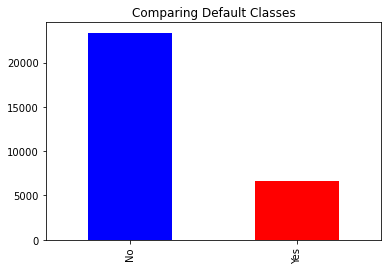

No     23364
Yes     6636
Name: default, dtype: int64


In [18]:
#Comparing percentage of defaults to non-defaults
data["default"].value_counts().plot.bar(color=['blue','red'])
plt.title("Comparing Default Classes")
plt.show()
print(data["default"].value_counts())

Individuals or partners have 22.12% chance of defaulting. The data is not balanced. During modeling, sampling techniques will be used to balance the data.

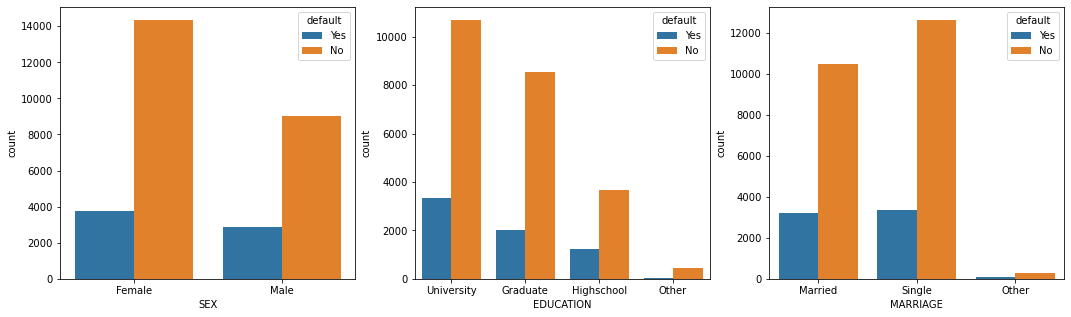

In [19]:
#Checking for relationships of categorical variables 
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x='SEX', hue='default', data=data)
plt.subplot(1,3,2)
sns.countplot(x='EDUCATION', hue='default', data=data)
plt.subplot(1,3,3)
sns.countplot(x='MARRIAGE', hue='default', data=data)
plt.show()

On SEX variable, there are more females and female defaulters.
On EDUCATION variable, University degree holders default more, followed by Graduate holders.
On MARRIAGE variable, Singles tend to default more but there is not a lot of differences between. 

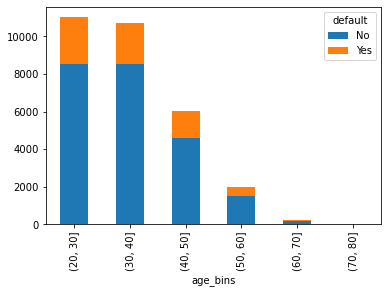

In [20]:
#Bivariate Analysis of LIMIT_BAL and AGE variables with the default variable.
data['age_bins']=pd.cut(data.AGE, bins=[20,30,40,50,60,70,80])
age_default=data.groupby(['age_bins','default']).AGE.count().unstack()
age_default.plot(kind='bar', stacked=True)
plt.show()

The amount of individuals defaulting is proportional to the total population of individuals in each age group but graph does indicate that individuals from age 20 to 40 are more likely to default.

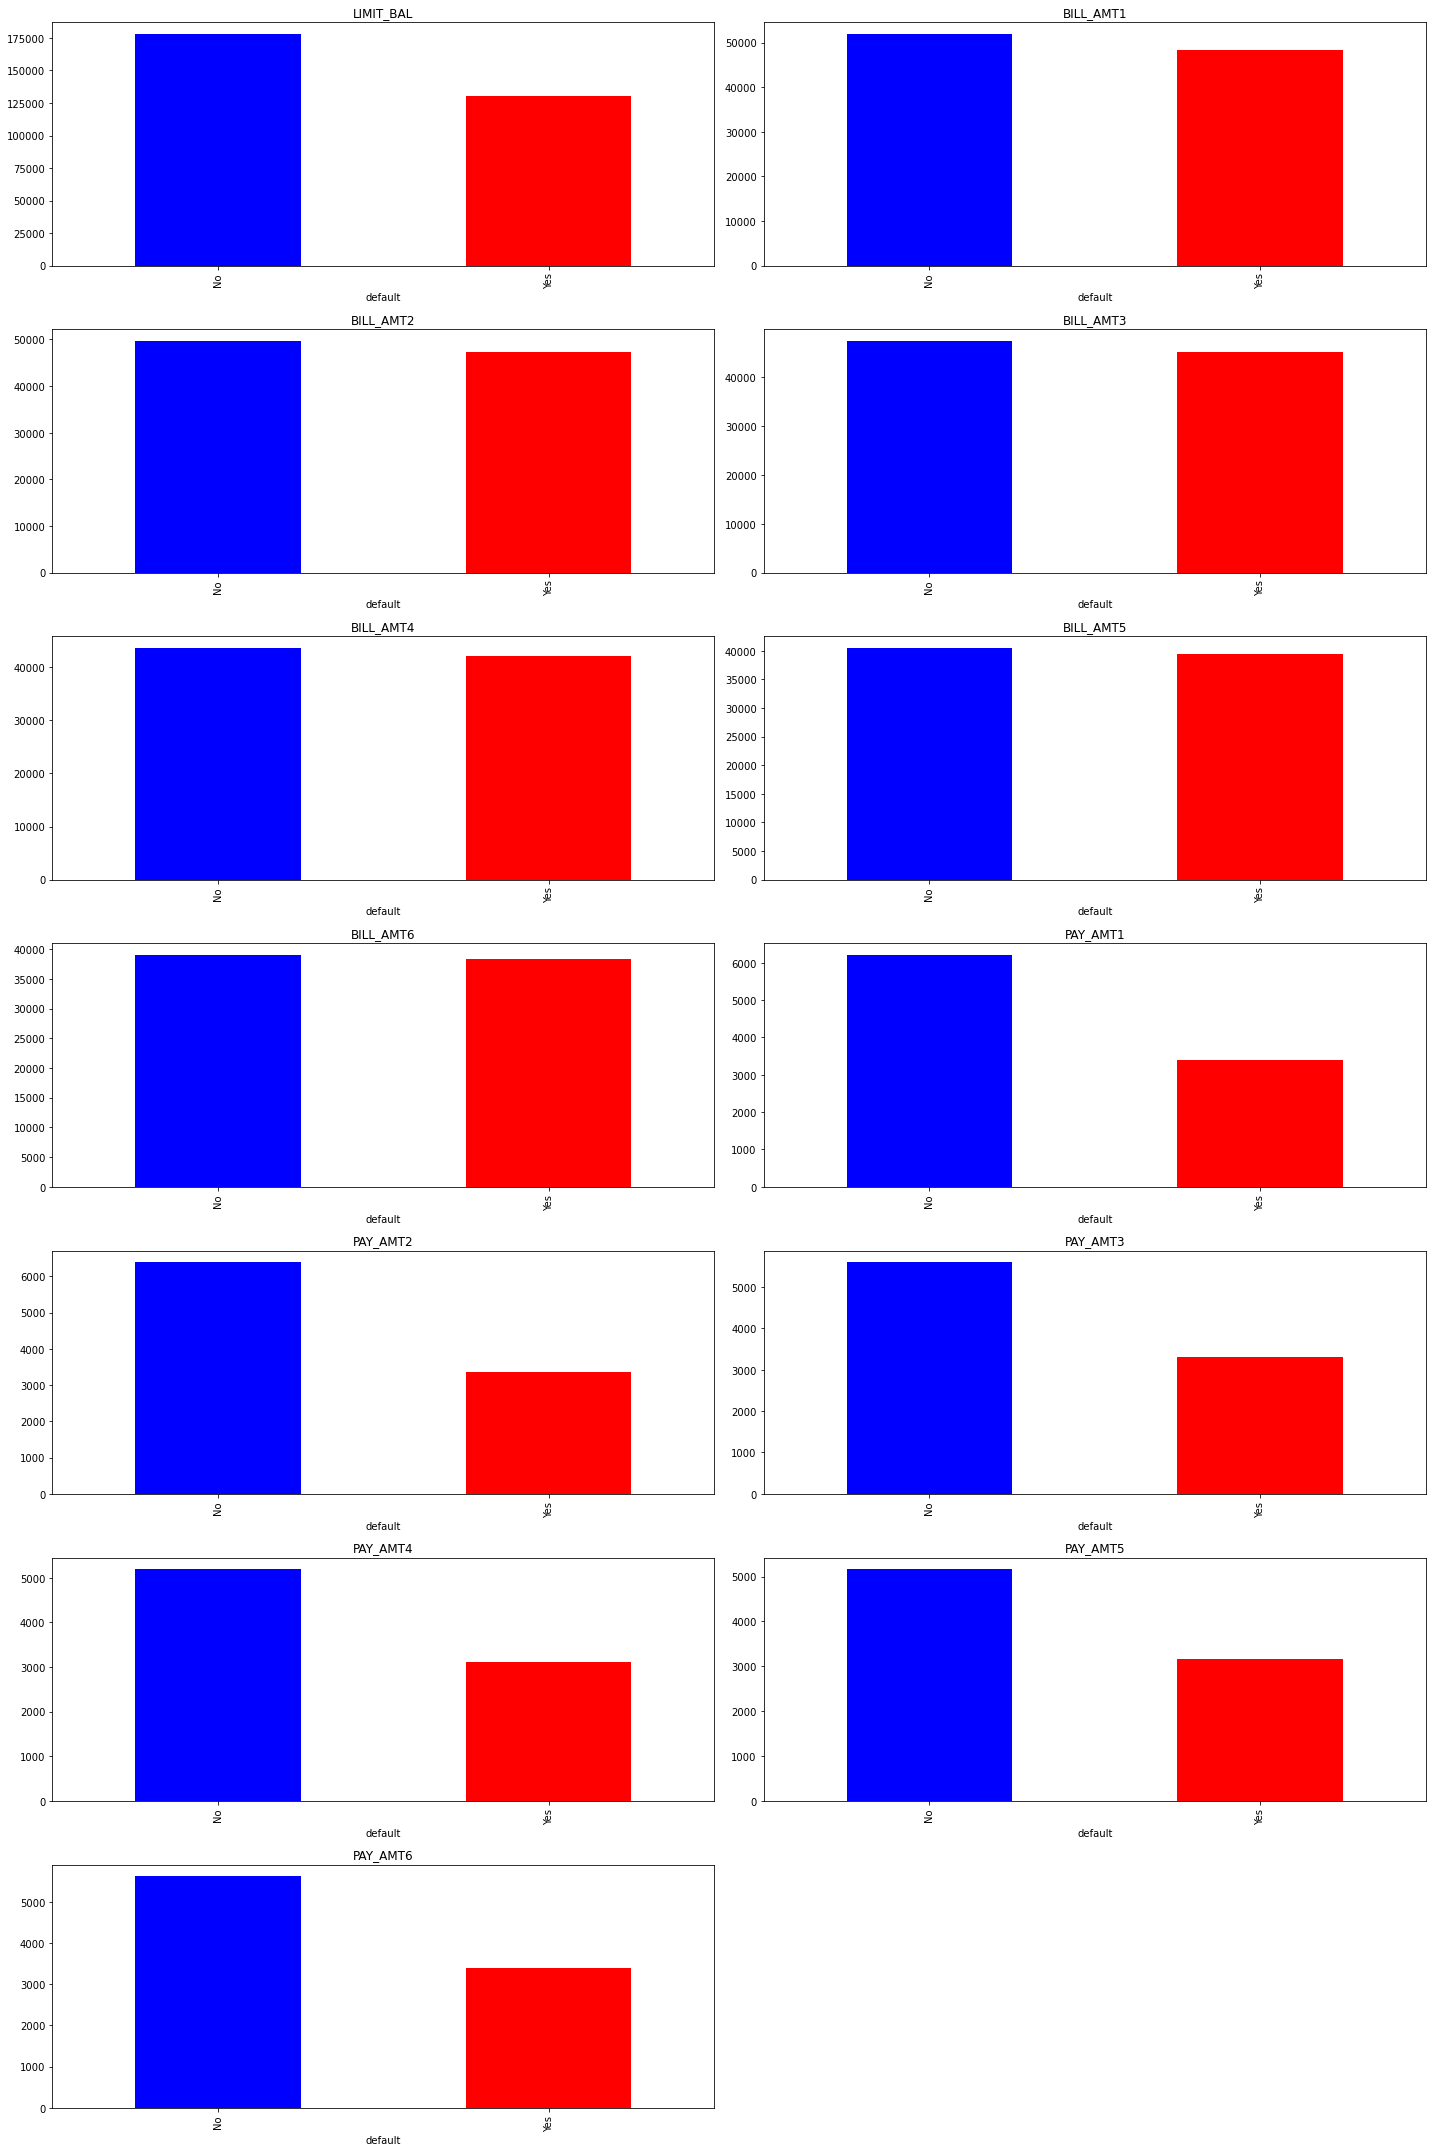

In [21]:
#Analyze continuous variables with defualt variable
k=1
plt.figure(figsize=(20,30))
for i in continuous_var:
    plt.subplot(7,2, k)
    k=k+1
    data.groupby("default")[i].mean().plot.bar(color=['blue','red'])
    plt.title(i)
plt.tight_layout()

There are significant differences in average value in few of the continuous variables. Keep in mind that these are winsorized variables.

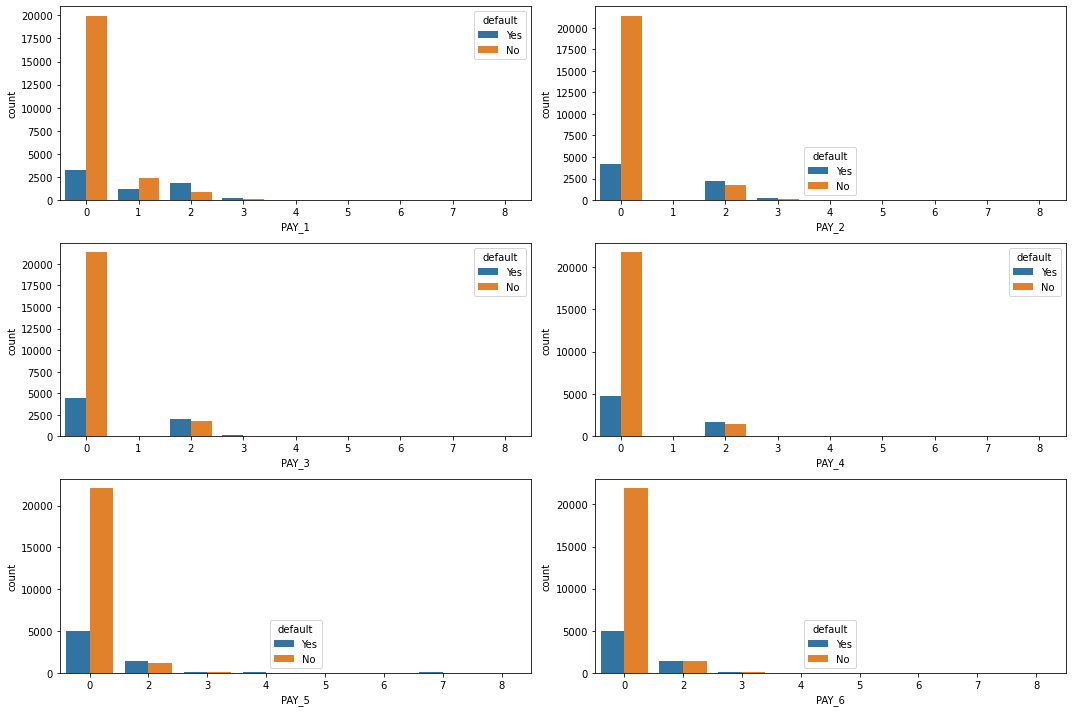

In [22]:
#Analyze the PAY columns
pay_col=['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
k=1
plt.figure(figsize=(15,10))
for i in pay_col:
    plt.subplot(3,2,k)
    k+=1
    sns.countplot(x=i, hue='default', data=data)
plt.tight_layout()

The graph above indicates that if individuals/partners will likely NOT default if payments are made ontime. However, if payments are late for 2-3 months, average numer of defaulters exceed the average number of non-defaulters. 

### Feature Engineering

In [23]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_bins
0,20000.0,Female,University,Married,24,2,2,0,0,0,...,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,Yes,"(20, 30]"
1,120000.0,Female,University,Single,26,0,2,0,0,0,...,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,Yes,"(20, 30]"
2,90000.0,Female,University,Single,34,0,0,0,0,0,...,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,No,"(30, 40]"
3,50000.0,Female,University,Married,37,0,0,0,0,0,...,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,No,"(30, 40]"
4,50000.0,Male,University,Married,57,0,0,0,0,0,...,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,No,"(50, 60]"


In [24]:
#Turn categorical variables back to numerical variables using one hot encoder
data.SEX.replace({"Female":2 ,"Male":1}, inplace=True)
data.EDUCATION.replace({"Graduate":1,"University":2,"Highschool":3,"Other":4},inplace=True)
data.MARRIAGE.replace({"Married":1,"Single":2,"Other":3},inplace=True)
data.default.replace({"Yes":1,"No":0}, inplace=True)

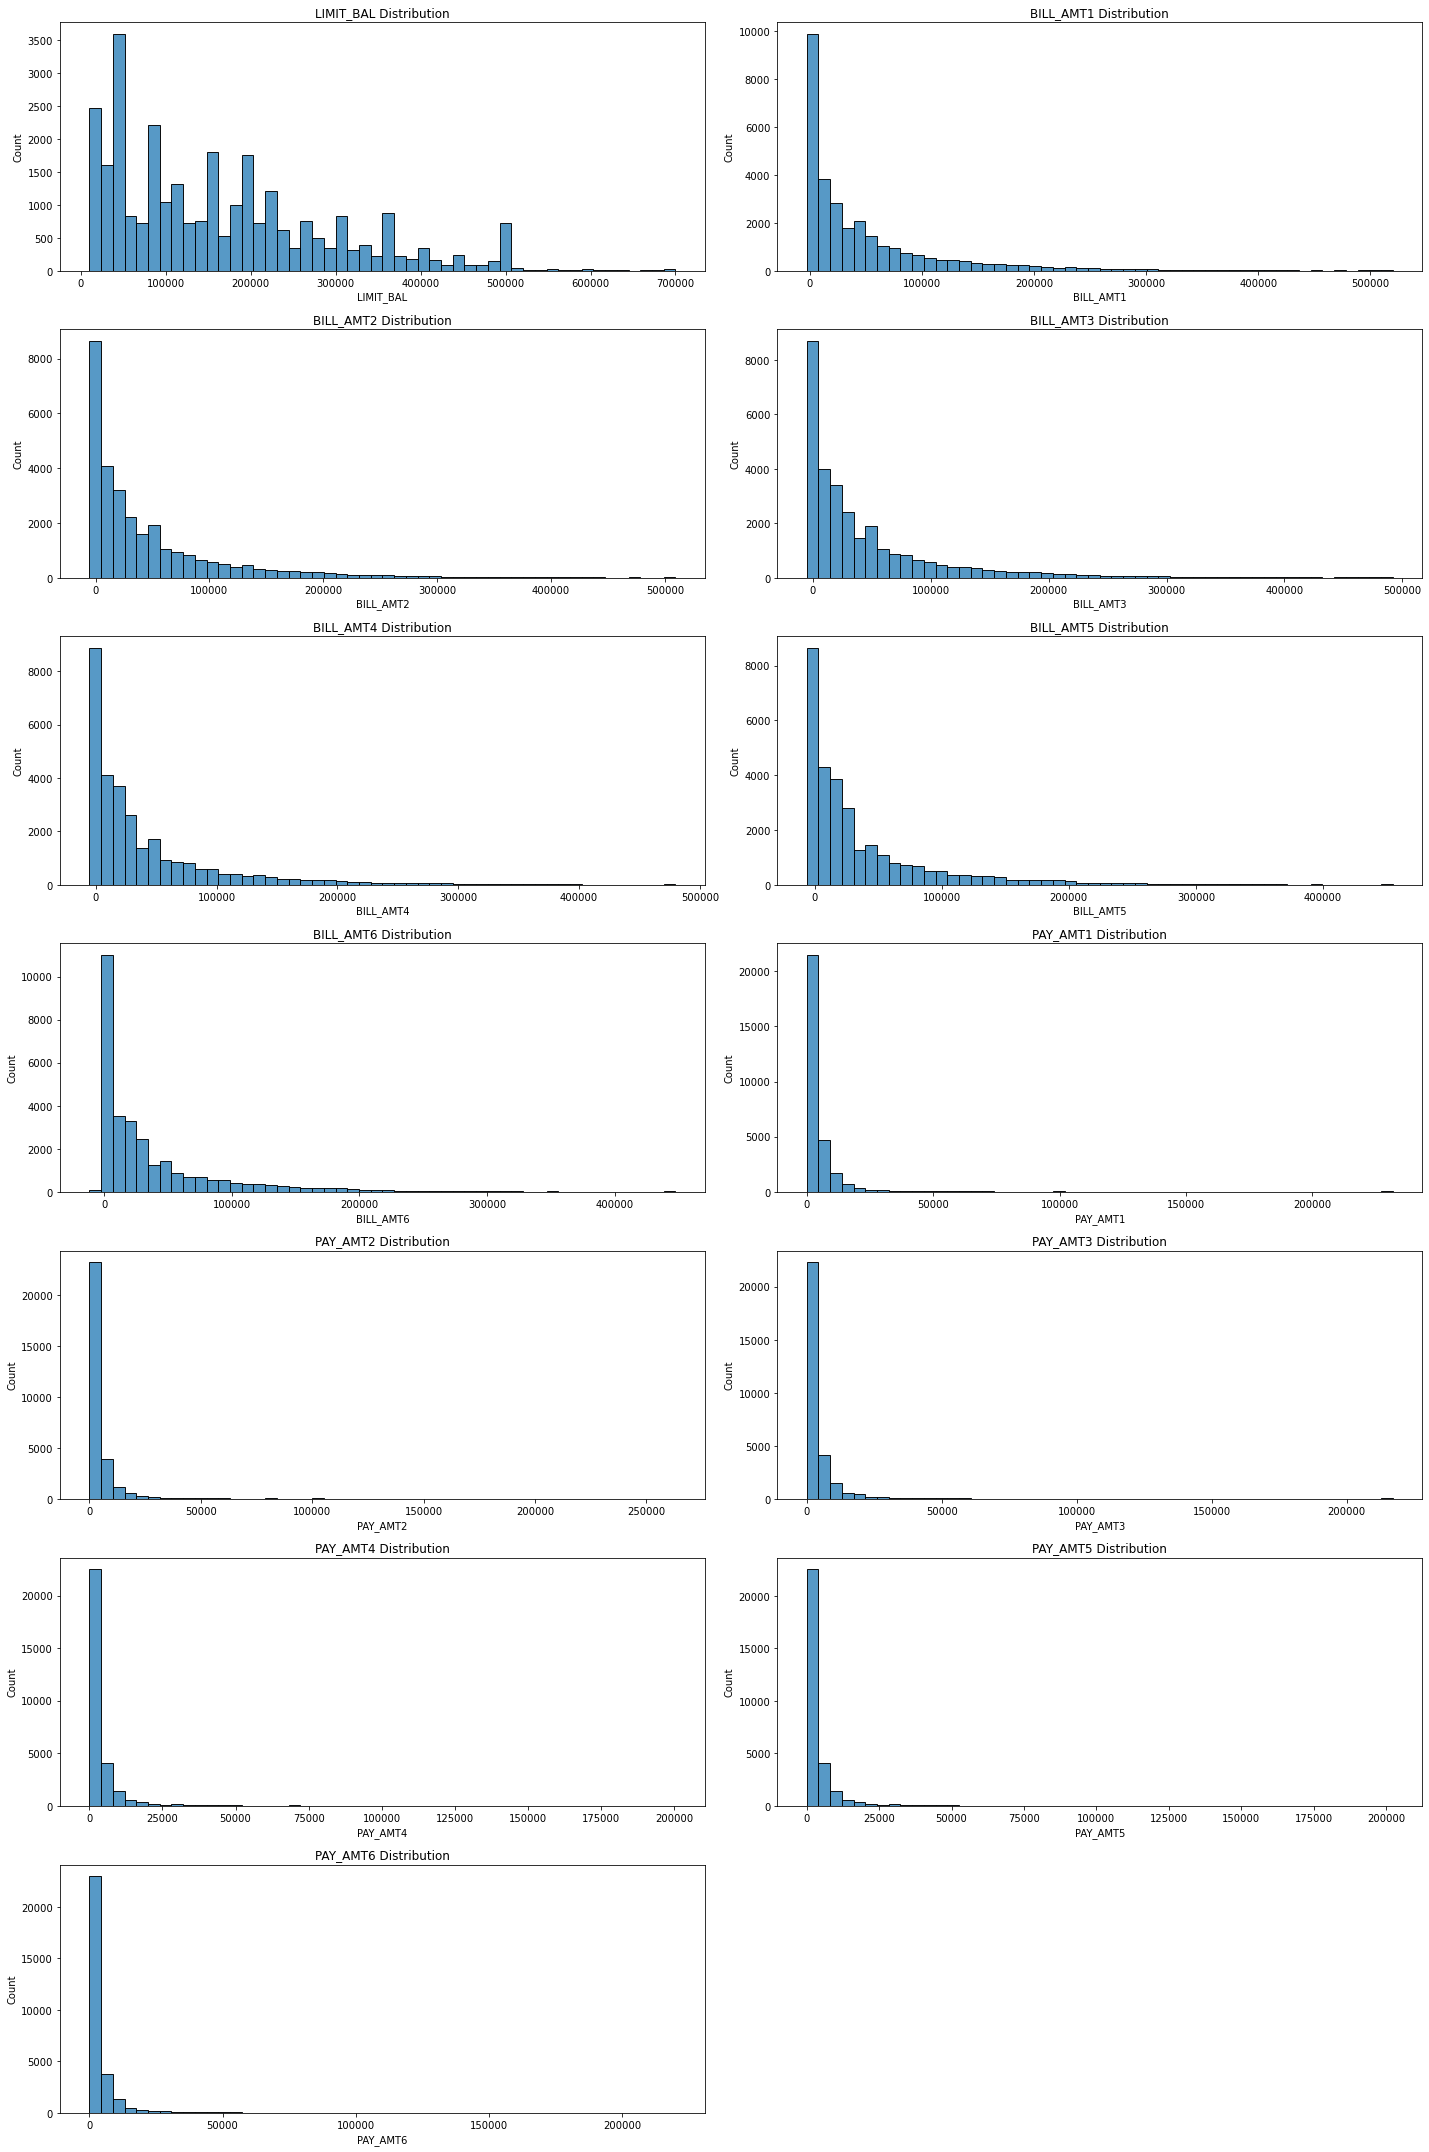

In [25]:
#Checking distribution of continiuous variables
k=1
plt.figure(figsize=(20,30))
for i in continuous_var:
    plt.subplot(7,2, k)
    k=k+1
    sns.histplot(data=data, x=i, bins=50)  
    plt.title(i+' Distribution')
plt.tight_layout()

In [26]:
#Continuous variables are not normally distributed. I will not normalize these variables.

In [27]:
#Looking into correlation between features and the target. Corr() can be used or heatmap. Heatmap provides a better visual.
#Look only to correlation between continuous and the target variables.  
abs(data.corr().loc[:,'default'].sort_values(ascending=False))

default      1.000000
PAY_1        0.396019
PAY_2        0.327093
PAY_3        0.286999
PAY_4        0.269055
PAY_5        0.260850
PAY_6        0.244437
EDUCATION    0.033842
AGE          0.013890
BILL_AMT6    0.004912
BILL_AMT5    0.006753
BILL_AMT4    0.010082
BILL_AMT3    0.013865
BILL_AMT2    0.014341
BILL_AMT1    0.019933
MARRIAGE     0.027575
SEX          0.039961
PAY_AMT6     0.056590
PAY_AMT5     0.060210
PAY_AMT4     0.063196
PAY_AMT3     0.065658
PAY_AMT2     0.076716
PAY_AMT1     0.079904
LIMIT_BAL    0.153615
Name: default, dtype: float64

In [28]:
X=data.drop(['default','age_bins'], axis=1)
y=data.default

In [29]:
#Scale and transform X
X_scaled=StandardScaler().fit_transform(X)

In [30]:
#Using pca to find number of best features to use for modeling
#Now apply the PCA to reduce number of dimensions
pca=PCA(n_components=0.95)
X_pca=pca.fit_transform(X_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >=0.95)
d

15

In [31]:
#Split the data to 75, 25.
X_train, X_test, y_train, y_test= train_test_split(X_pca, y ,test_size=0.25)

# Modeling

In [32]:
#Build functions for Logistic Regression, Random Forest, and KNN 
rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = best_params['penalty'],
                              random_state=rs, 
                              max_iter = 1000,
                              solver=best_params['solver'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

#Build Random Forest Classifier Model
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = True,
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

#Build KNN Model
def build_knn(X_train, y_train, X_test, best_params, threshold=0.5):
    model=KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                               algorithm=best_params['algorithm'],
                               weights=best_params['weights'])
    
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

In [33]:
#As a reminder, the data is not balanced, where the minority class accounts for only 22%. 
#Therefore, will use oversampling(SMOTE) and undersampling methods to balance the data.
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

In [34]:
#Evaluating metrics
rs = 123
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

In [35]:
def visualize_eval_metrics(results, title):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    smote = df.iloc[1, 1:].values
    under = df.iloc[2, 1:].values
    width = 0.2
    plt.figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, smote, width, color='#d35400')
    plt.bar(x+0.2, under, width, color='#2980b9')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "SMOTE", "Undersampling"])
    plt.title(title + "Models")
    plt.show()

#### Logistic Regression

In [36]:
results=[] #empty list to hold scores

In [37]:
#Try GridSearchCV for Logistic Regression
#Define parameters
lr_params={'penalty':['l2','l1','none'], 
           'solver':['newton-cg','lbfgs','liblinear','sag','saga']}

In [38]:
#Define base model
lr_grid_model=LogisticRegression()
#Implement GridSearch
lr_search = GridSearchCV(estimator=lr_grid_model, param_grid=lr_params, scoring='f1',cv=5)
lr_search.fit(X_train, y_train)
print(lr_search.best_params_)
print(lr_search.best_score_)
lr_parameters=lr_search.best_params_

{'penalty': 'none', 'solver': 'newton-cg'}
0.4195060903589084


In [39]:
# Getting results using original data
pred, lr_model=build_lr(X_train, y_train, X_test, best_params=lr_parameters)
result=evaluate(y_test, pred, eval_type='Original')
results.append(result)

#Getting results from using SMOTE (upsampling)
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)
pred, lr_model_US=build_lr(X_smo, y_smo, X_test, best_params=lr_parameters)
result=evaluate(y_test, pred, eval_type='SMOTE')
results.append(result)

#Gettin results fomr using down sampling (RandomSampling)
pred, lr_model_DS=build_lr(X_under, y_under, X_test, best_params=lr_parameters)
result=evaluate(y_test, pred, eval_type='Undersampling')
results.append(result)

In [40]:
lr_results=results

            type  accuracy    recall       auc  precision    fscore
0       Original  0.817333  0.312192  0.634568   0.667105  0.318714
1          SMOTE  0.778933  0.570813  0.703633   0.490996  0.567266
2  Undersampling  0.777067  0.570197  0.702219   0.487368  0.566494


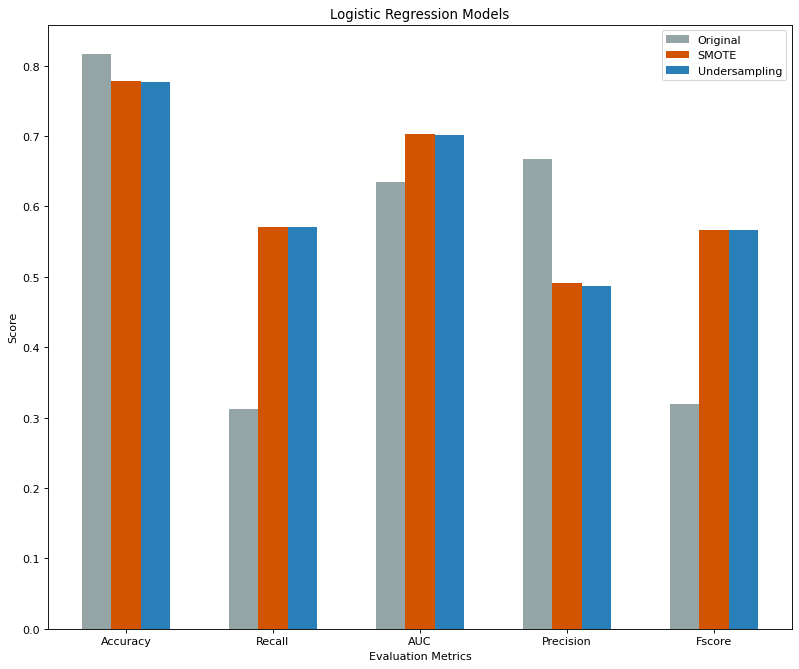

In [41]:
visualize_eval_metrics(lr_results, title="Logistic Regression ")

SMOTE and Undersampling models perform the better in terms of recall, auc, and f1 score. Smote performs slighly better in terms of recall, auc, and f1 score.

#### Random Forest Models

In [42]:
results=[] #empty list to hold scores

In [43]:
#Use Grid Search CV for Random Forest Model
#Define params
rf_params = {'max_depth': [5, 10, 15, 20],
             'n_estimators': [25, 50, 100],
             'min_samples_split': [2, 5]}
#Define base model
rfc_model_grid=RandomForestClassifier()
#Implement GridSearchCV
rfc_search = GridSearchCV(estimator=rfc_model_grid, param_grid=rf_params,scoring='f1')
rfc_search.fit(X_train, y_train)
print(rfc_search.best_params_)
print(rfc_search.best_score_)
rfc_parameters=rfc_search.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
0.463587049487424


In [44]:
# Getting results using original data
pred, rfc_model=build_rf(X_train, y_train, X_test, best_params=rfc_parameters)
result=evaluate(y_test, pred, eval_type='Original')
results.append(result)

#Getting results from using SMOTE (upsampling)
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)
pred, rfc_model_US=build_rf(X_smo, y_smo, X_test, best_params=rfc_parameters)
result=evaluate(y_test, pred, eval_type='SMOTE')
results.append(result)

#Gettin results fomr using down sampling (RandomSampling)
pred, rfc_model_DS=build_rf(X_under, y_under, X_test, best_params=rfc_parameters)
result=evaluate(y_test, pred, eval_type='Undersampling')
results.append(result)

            type  accuracy    recall       auc  precision    fscore
0       Original  0.814133  0.346675  0.645002   0.628348  0.352757
1          SMOTE  0.770667  0.550493  0.691005   0.474522  0.547124
2  Undersampling  0.743867  0.630542  0.702865   0.436674  0.619956


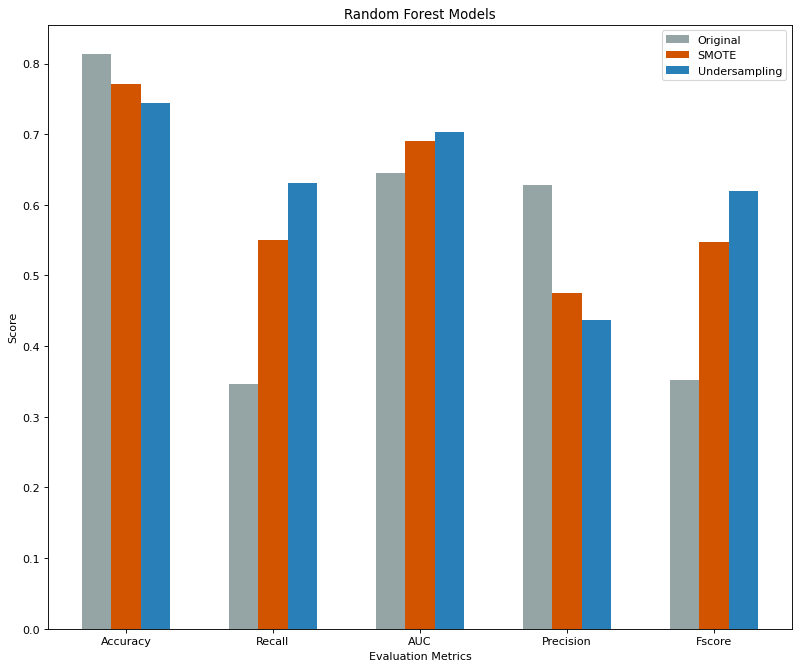

In [45]:
rfc_results=results
visualize_eval_metrics(rfc_results, title="Random Forest ")

In random forest, SMOTE and Undersampling are performing better in terms of recall, AUC, and f1 score. Undersampling does a little better than SMOTE. Random forest does perform a little better than logistic regression but it's computation time is much more.

#### K Nearest Neighbors (KNN)

In [46]:
results=[] #empty list to hold scores

In [47]:
#Use Grid Search for KNN

#Define params
param_grid = {'n_neighbors': [k for k in range(20)],
              'weights':['uniform','distance'],
             'algorithm':['ball_tree','kd_tree','brute']}

#Define base model
knn_model=KNeighborsClassifier()

#Implement GridSearchCV
knn_search = GridSearchCV(estimator=knn_model, param_grid=param_grid,scoring='f1')
knn_search.fit(X_train, y_train)

print(knn_search.best_params_)
print(knn_search.best_score_)
knn_params=knn_search.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 19, 'weights': 'distance'}
0.45327564334753234


In [48]:
# Getting results using original data
pred, knn_model=build_knn(X_train, y_train, X_test, best_params=knn_params)
result=evaluate(y_test, pred, eval_type='Original')
results.append(result)

#Getting results from using SMOTE (upsampling)
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)
pred, knn_model_US=build_knn(X_smo, y_smo, X_test, best_params=knn_params)
result=evaluate(y_test, pred, eval_type='SMOTE')
results.append(result)

#Gettin results fomr using down sampling (RandomSampling)
pred, knn_model_DS=build_knn(X_under, y_under, X_test, best_params=knn_params)
result=evaluate(y_test, pred, eval_type='Undersampling')
results.append(result)

            type  accuracy    recall       auc  precision    fscore
0       Original  0.812667  0.360837  0.649190   0.614900  0.366664
1          SMOTE  0.680800  0.660714  0.673533   0.367970  0.641098
2  Undersampling  0.722933  0.639163  0.692624   0.410277  0.625736


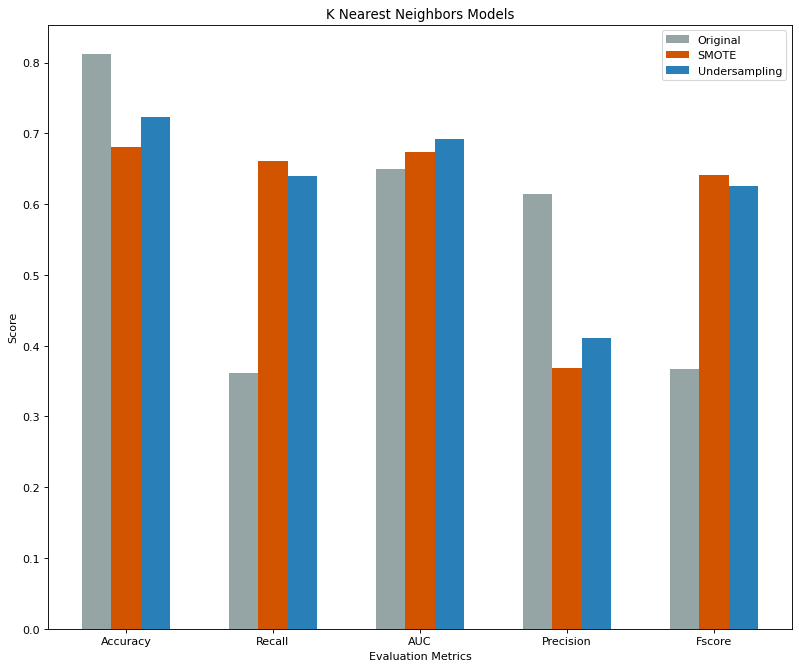

In [49]:
knn_results=results
visualize_eval_metrics(knn_results, title="K Nearest Neighbors ")

On knn model, SMOTE and Undersampling perform better and are par with each other. I will select Smote is better performing as its recall and f1 scores are higher.

In [50]:
lr_results=pd.DataFrame(lr_results) #Best model is SMOTE
rfc_results=pd.DataFrame(rfc_results) #Undersampling
knn_results=pd.DataFrame(knn_results) #SMOTE

In [51]:
LR=lr_results.iloc[1,1:].values
RFC=rfc_results.iloc[2,1:].values
KNN=knn_results.iloc[1,1:].values

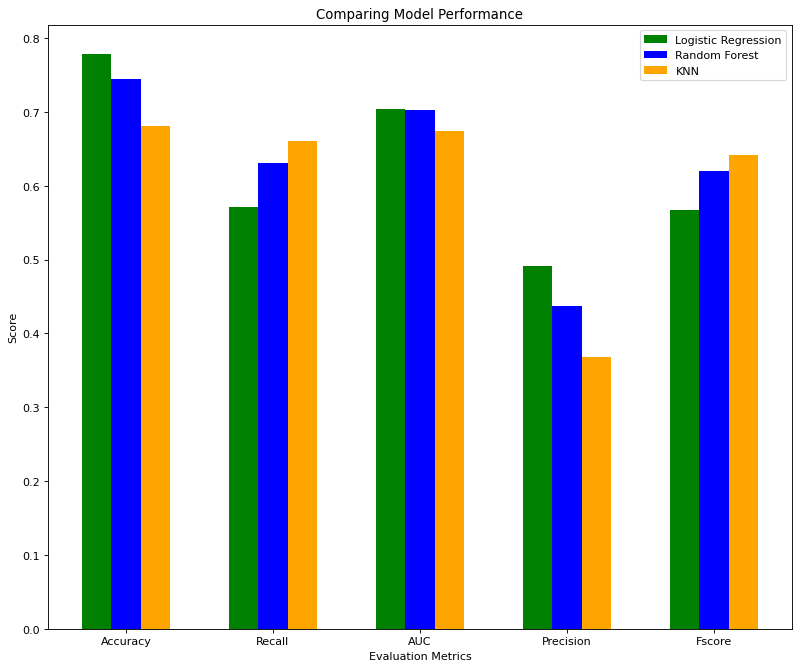

In [52]:
#Lets graph the final scores to compare between Models
x = np.arange(5)
width = 0.2
plt.figure(figsize=(12, 10), dpi=80)
plt.bar(x-0.2, LR, width, color='green')
plt.bar(x, RFC, width, color='blue')
plt.bar(x+0.2, KNN, width, color='orange')
plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.legend(["Logistic Regression", "Random Forest", "KNN"])
plt.title("Comparing Model Performance")
plt.show()

In [53]:
model_table=pd.DataFrame({'Logistic Regression':LR, 'Random Forest':RFC,'KNN':KNN}, index=['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
model_table

,Logistic Regression,Random Forest,KNN
Accuracy,0.778933,0.743867,0.6808
Recall,0.570813,0.630542,0.660714
AUC,0.703633,0.702865,0.673533
Precision,0.490996,0.436674,0.36797
Fscore,0.567266,0.619956,0.641098


Random Forest and KNN perform slighly better than Logistic Regression, but they are computationally intensive.  

# Summary and Results

### Objective
The objective of this task is to analyze the "UCI Credit Card" dataset to predict if the consumer will default on their next month payment.

Why predicting consumer defaults important?

-Total credit card debt in the US is more than 900 billion dollars where 1.57% are in delinquencies, meaning that 14 billion dollars are not paid on time.
    
-Predicting will lead banks to choose appropriate individuals to receive the loan and save money by reducing the number of loans given to individuals that are likely to default. 


### Data Description
Data consists of 30,000 samples and 23 variables, containing information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

UCI Credit Card dataset can be accessed from https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset


### Methods Used 

The data is not balanced where default customers only account for ~22%. I will sampling techniques balance the data during modeling phase. Data was checked for missing values but none were found, and outliers in continuous variables using boxplot. Using winsorization, outliers were modified.

Primarily, graphs were used to conduct univariate and bivariate analysis of the variables. Education, sex, marriage, age, pay variables correlate with defualt outcome. Furthermore, there is a correlation between amount billed to and payed by two classes, but not much correlation between classes for average amount billed.

Features were identified based on their correlation with the default variable and based on the analysis during EDA. However, primarily PCA was used to select best features that maintained 95% variance, where number of features is 15. PCA data is used for modeling after scaling using StandardScaler and splitting into X_train and X_test, labeled as original data. This data was oversampled and undersampled using SMOTE and RandomUnderSampling to balance the data. The balanced datas were also used in training the models to compare their performance to models trained using original data.


### Summary of the Models Used and Best Model
This is a classification task. Models trained include Logistic Regression, Random Forest Classifier, and KNN. GridSearchCV is used to find best parameters to utalize. Each model was trained using original, SMOTE and undersampled data, and compared using accuracy, recall, precision, AUC, and f1 scores.

KNN and Random Forest performed better than Logistic Regression and either can be used as the best models. However, if companies don't want computationally intensive model, Logistic Regression is better.


### Best Insight
The best predictor of an individual who would default is their history of monthly payments, as described with PAY_0 to PAY_6 variables. There are differences in classes within variables as education, sex, marriage, and age in terms of defaults. For example, university degree holders default more than high school diploma holders.


### Recommendation:
Other features like credit score, individuals salary, and their total dept can have high correlation with the default outcome. If these features can be collected, next steps would analyze and integrate them into our model.